## **Name**          : Cheruvu Surya Sai Ram
## **Roll Number**   : 19EC39008
## **Project Code**  : EOHC-DC
## **Project Title** : Economic Outlook Categorization using Complete Linkage Divisive (Top-Down) Clustering Technique

###**Importing required libraries**

In [330]:
#All the required libraries are imported here
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

#####Function for **outlier removal** in the dataset

In [331]:
def outlier_removal(frame) :
  frame1 = frame.copy()
  for column in frame1.columns[2:]:                                #the first two columns are categorical
    mu = frame1[column].mean()
    sigma = frame1[column].std()
    frame1 = frame1[~((frame1[column] - mu).abs() > 3 * sigma)]   
    frame1 = frame1.reset_index(drop=True)
  return frame1

#####Function that **standardizes** the input dataframe

In [332]:
def standardize(frame) :
  frame1 = frame.copy()
  for column in frame1.columns:
    mu = frame1[column].mean()                      #mean
    sigma = frame1[column].std()                    #standard deviation
    frame1[column] = (frame1[column] - mu) / sigma
  return frame1

#####Function to calculate the **distance** between two feature vectors using **cosine similarity**

In [333]:
def cos_dist(x1, x2) :
  #calculating the norms
  norm1 = np.linalg.norm(x1)
  norm2 = np.linalg.norm(x2)

  #handling overflow case
  if norm1==0 or norm2==0 :
    return 1
  #distance is calculated as 1-similarity
  else:
    return 1-((np.dot(x1,x2))/(norm1*norm2))   

#####Function to perform **K Means Clustering** on input dataset given the values of number of clusters and maximum number of iterations

In [334]:
def KMeans(X, k=3, max_iter=20) :
  n,m = X.shape  
  np.random.seed(123)                                #setting a seed value
  ind = np.random.choice(n,k,replace=False)      
  means = X[ind]                                     #choosing k distinct centres randomly

  dist = np.zeros((n,k))
  clusters = np.zeros(n, dtype = np.int64)           #used for storing the cluster label of every sample

  #Iterating for the given number of iterations
  #In the question, it is said to do it for 20 iterations
  for iteration in range(max_iter) :
    for i in range(n) :
      for j in range(k) :
        dist[i][j] = cos_dist(X[i],means[j])         #calculating the distance of every sample from every centre

    for i in range(n) :
      clusters[i] = np.argmin(dist[i])               #finding the centre at the minimum distance and accordingly assigning the cluster

    for i in range(k) :
      means[i] = np.mean(X[clusters==i], axis=0)     #updating the centres

  #Converting the cluster of every sample into sets of clusters
  #Initialization
  cluster_set = []
  for i in range(k) :
    cluster_set.append([])
  #Forming sets of clusters
  for i in range(n) :
    cluster_set[clusters[i]].append(i)

  #Saving a .txt file with cluster information in the given format
  f = open('K_means_'+str(k)+'.txt','w')
  cluster_set.sort(key=min)
  for c in cluster_set:
    sorted_c = sorted(c)
    f.write(','.join(str(i) for i in sorted_c) + '\n')

  #both cluster labels and sets of clusters are returned
  return clusters, cluster_set

#####Function to calculate the **Silhouette Coefficient** given the dataset and cluster information

In [335]:
def SC(X, labels) :
  n, m = X.shape
  clusters = np.unique(labels)
  cluster_num = len(clusters)

  #Calculating the pairwise distances between every two data points
  dist = np.zeros((n,n))
  for i in range(n) :
    for j in range(n) :
      dist[i][j] = cos_dist(X[i],X[j])

  #Calculating the intra cluster distance for each point
  array_a = np.zeros(n)
  for i in range(n) :
    cluster = labels[i]
    array_a[i] = np.mean(dist[i][labels==cluster])

  #Calculating the distance of each point with next nearest clsuter
  array_b = np.zeros(n)
  for i in range(n) :
    cluster = int(labels[i])
    mask = np.ones(cluster_num, dtype=bool)
    mask[cluster] = False
    array_b[i] = np.min([np.mean(dist[i][labels == c]) for c in clusters[mask]])

  #calculating Silhouette Coefficient for each data point
  sc = np.zeros(n)
  for i in range(n) :
    sc[i] = (array_b[i]-array_a[i])/max(array_a[i],array_b[i])

  return np.mean(sc)



#####Function to calculate the **optimal value of k** out of 3,4,5 and 6 using the obtained Silhouette Scores

In [336]:
def find_best_k (X) :
  sc_max=-1                           #initializing best Silhouette score with the least value
  for k in [3,4,5,6] :
    clustering = KMeans(X, k)         #performing K Means clustering
    sc = SC(X, clustering[0])         #we use the first return value for Silhouette Score calculation
    print(f'\nThe Silhouette Score on using k = {k} is {sc : .6f}')

    #Updating the value of best_k according to the obtained Silhouette Score
    if sc>sc_max :
      sc_max = sc
      best_k = k
  return best_k

#####Function to perform **Complete Linkage Divisive Clustering** on input dataset given the number of clusters

In [337]:
def CLDC(X, k):
    n_points, n_features = X.shape
    cluster_set = [list(range(n_points))]                        #single cluster containing all points

    while len(cluster_set) < k:                                  #stop when k clusters are obtained
        #Variables required for intermediate computation
        p = 0
        q = 0
        split = None
        maxval = -np.inf

        #Iterating through the set of clusters
        for i, c in enumerate(cluster_set):
            n = len(c)                      
            dist = np.zeros((n,n))
            #Calculating the distance between every pair of points in the cluster
            for u in range(n) :
              for v in range(n) :
                dist[u][v] = cos_dist(X[c[u]],X[c[v]])
            
            #COMPLETE LINKAGE
            #Finding the maximum distance and the corresponding points
            if np.max(dist) > maxval:
                split = i                                         #storing the cluster to be split
                p, q = np.unravel_index(dist.argmax(), dist.shape)
                maxval = np.max(dist)

        #DIVISIVE CLUSTERING
        #Splitting the selected cluster
        c1 = []
        c2 = []
        for i in cluster_set[split]:
            #assigning a point to a cluster based on to which point it is nearest to
            if cos_dist(X[i], X[cluster_set[split][q]]) < cos_dist(X[i], X[cluster_set[split][p]]) :
                c1.append(i)
            else:
                c2.append(i)
        # Remove the splitted cluster and add the new generated clusters
        cluster_set.append(c1)
        cluster_set.append(c2)
        del cluster_set[split]

    #Saving a .txt file with cluster information in the given format
    f = open('Divisive_'+str(k)+'.txt','w')
    cluster_set.sort(key=min)
    for c in cluster_set:
      sorted_c = sorted(c)
      f.write(','.join(str(i) for i in sorted_c) + '\n')

    #Converting the set of clusters into cluster label of each point
    clusters = np.zeros(n_points, dtype=np.int64)
    for i, point in enumerate(cluster_set):
      clusters[point] = i

    return clusters, cluster_set

#####Function to calculate the **Jaccard Similarity** of 2 arrays

In [338]:
def jaccard_sim(array1, array2) :
  array1 = np.array(array1)
  array2 = np.array(array2)
  intersection = np.intersect1d(array1, array2)         #calculation of intersection
  union = np.union1d(array1, array2)                    #calculation of union
  return float(len(intersection)) / len(union)

#####Function to **map the corresponding sets of clusters** using **Jaccard Similarity** and then calculating the Jaccard Similarity values

In [339]:
def mapping_Jaccard(clustering1, clustering2) :               #The inputs are sets of clusters
  n = len(clustering1)                                        #number of clusters
  mapping = np.zeros(n, dtype=np.int64)                       #stores mapping of cluster set with another cluster set

  #Finding the corresponding set of cluster using maximum Jaccard Similarity
  for i in range(n) :
    sim = -1
    for j in range(n) :
      if jaccard_sim(clustering1[i], clustering2[j]) > sim :
        sim = jaccard_sim(clustering1[i], clustering2[j])
        mapping[i] = j

  #Using the obtained mapping, calculating the Jaccard similarity values
  scores = []
  for i in range(n) :
    scores.append(jaccard_sim(clustering1[i], clustering2[mapping[i]]))
  
  #printing the values
  print('\nThe mapping of clusters is as follows : \n')
  for i in range(n) :
    print(f'{i} ---> {mapping[i]}', end='\t')
  print('\nThe Jaccard Similarity values of the corresponding clusters are as follows : \n')
  for i in range(n) :
    print(f'{scores[i] : .6f}', end='\t')
  return scores

###**Loading the data**

In [340]:
#Google drive is mounted
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create a folder called EOHC_DC in your google drive and upload the dataset file in that folder **before running the below cell**.

In [341]:
#Reading the dataset file
dataset = pd.read_csv('drive/MyDrive/EOHC_DC/eoutlookTS.csv')
dataset.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Attribute,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,Base Year,Unnamed: 16
0,Philippines,566,"External Trade, Imports of Goods and Services,...",TM_R_PC_PP_PT,Value,NaN,0.200799,14.905583,13.226791,9.002666,2.787334,5.241875,5.730075,5.502134,6.074727,NaN,NaN
1,Singapore,576,"External Trade, Imports of Goods and Services,...",TM_R_PC_PP_PT,Value,NaN,5.390545,5.330872,7.044583,0.825551,1.330361,3.921043,4.328353,4.447906,4.849560,NaN,NaN
2,Thailand,578,"External Trade, Imports of Goods and Services,...",TM_R_PC_PP_PT,Value,NaN,1.578705,-5.279759,0.806382,-3.181700,3.474188,3.536731,3.644354,3.979334,3.840477,NaN,NaN
3,Vietnam,582,"External Trade, Imports of Goods and Services,...",TM_R_PC_PP_PT,Value,NaN,19.266017,14.087290,20.779727,11.365084,8.207265,12.039589,13.399777,13.050892,13.015151,NaN,NaN
4,Bhutan,514,"External Trade, Imports of Goods and Services,...",TM_R_PC_PP_PT,Value,NaN,-15.212637,-4.946150,-0.084670,8.053188,5.409294,-1.913507,-0.225860,-4.796220,0.861616,NaN,NaN


###**Preprocessing the dataset**

Removing all the columns with **all NULL** values

In [342]:
dataset.dropna(how='all', axis='columns',inplace=True)
dataset.shape

(368, 14)

We see that the feature ***Attribute*** has **only one unique value** and hence has no effect on clustering. 

In [343]:
dataset['Attribute'].unique()

array(['Value'], dtype=object)

We observe that **Indicator Name and Indicator Code features are equivalent**. There exists a one to one mapping between them as shown below. 

In [344]:
dataset.groupby('Indicator Name')['Indicator Code'].unique()

Indicator Name
Balance of Payments, Current Account, Total, Net, In billions of US Dollars                    [BCA_BP6_USD]
Balance of Payments, Current Account, Total, Net, Percent of GDP                            [BCA_GDP_BP6_PT]
External Trade, Exports of Goods and Services, Percent Change                                [TX_R_PC_PP_PT]
External Trade, Imports of Goods and Services, Percent Change                                [TM_R_PC_PP_PT]
Fiscal, General Government, Gross debt position, 2001 Manual, Percent of FY GDP          [GGXWDG_G01_GDP_PT]
Fiscal, General Government, Net lending/borrowing, 2001 Manual, Percent of FY GDP        [GGXCNL_G01_GDP_PT]
National Accounts, Gross Domestic Product in US Dollars, Constant Prices, in billions            [NGDPD_USD]
National Accounts, Gross Domestic Product, Real, Constant Prices, Percent Change           [NGDP_R_PC_PP_PT]
National Accounts, Total Domestic Demand, Real, Constant Prices, Percent Change            [NTDD_R_PC_PP_PT]
Pric

Also we observe that **Country Name and Country Code features are equivalent**. There exists a one to one mapping between them as shown below. 

In [345]:
dataset.groupby('Country Name')['Country Code'].unique()

Country Name
ASEAN                                [511]
Asia                                 [229]
Australia                            [193]
Bangladesh                           [513]
Bhutan                               [514]
Brunei Darussalam                    [516]
Cambodia                             [522]
China, P.R.: Hong Kong               [532]
China, P.R.: Macao                   [546]
China, P.R.: Mainland                [924]
Fiji                                 [819]
India                                [534]
Indonesia                            [536]
Japan                                [158]
Kiribati                             [826]
Korea, Republic of                   [542]
Lao People's Democratic Republic     [544]
Malaysia                             [548]
Maldives                             [556]
Marshall Islands, Republic of        [867]
Micronesia, Federated States of      [868]
Mongolia                             [948]
Myanmar                              [518

The **irrelevant features** from the above analysis are removed from the dataset.

In [346]:
dataset.drop(['Country Name','Indicator Name','Attribute'],axis=1,inplace=True)
dataset.shape

(368, 11)

The **categorical attributes** *Indicator Code* and *Country Code* are converted to numerical attributes on using the below cell.

In [347]:
cat1 = pd.Categorical(dataset['Indicator Code'])
mapping1 = dict(enumerate(cat1.categories))
cat2 = pd.Categorical(dataset['Country Code'])
mapping2 = dict(enumerate(cat2.categories))

print('The mapping of Indicator Code feature is as follows : \n')
print(mapping1)
print('\nThe mapping of Country Code feature is as follows : \n')
print(mapping2)

The mapping of Indicator Code feature is as follows : 

{0: 'BCA_BP6_USD', 1: 'BCA_GDP_BP6_PT', 2: 'GGXCNL_G01_GDP_PT', 3: 'GGXWDG_G01_GDP_PT', 4: 'NGDPD_USD', 5: 'NGDP_R_PC_PP_PT', 6: 'NTDD_R_PC_PP_PT', 7: 'PCPI_PC_PP_PT', 8: 'TM_R_PC_PP_PT', 9: 'TX_R_PC_PP_PT'}

The mapping of Country Code feature is as follows : 

{0: 158, 1: 193, 2: 196, 3: 229, 4: 511, 5: 513, 6: 514, 7: 516, 8: 518, 9: 522, 10: 524, 11: 528, 12: 532, 13: 534, 14: 536, 15: 537, 16: 542, 17: 544, 18: 546, 19: 548, 20: 556, 21: 558, 22: 565, 23: 566, 24: 576, 25: 578, 26: 582, 27: 813, 28: 819, 29: 826, 30: 846, 31: 853, 32: 862, 33: 866, 34: 867, 35: 868, 36: 869, 37: 924, 38: 948, 39: 9502}


In [348]:
dataset['Indicator Code'] = cat1.codes
dataset['Country Code'] = cat2.codes
dataset

,Country Code,Indicator Code,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,23,8,2.007986e-01,1.490558e+01,1.322679e+01,9.002666e+00,2.787334e+00,5.241875e+00,5.730075e+00,5.502134e+00,6.074727e+00
1,24,8,5.390545e+00,5.330872e+00,7.044583e+00,8.255513e-01,1.330361e+00,3.921043e+00,4.328353e+00,4.447906e+00,4.849560e+00
2,25,8,1.578705e+00,-5.279759e+00,8.063819e-01,-3.181700e+00,3.474188e+00,3.536731e+00,3.644354e+00,3.979334e+00,3.840477e+00
3,26,8,1.926602e+01,1.408729e+01,2.077973e+01,1.136508e+01,8.207265e+00,1.203959e+01,1.339978e+01,1.305089e+01,1.301515e+01
4,6,8,-1.521264e+01,-4.946150e+00,-8.466965e-02,8.053188e+00,5.409294e+00,-1.913507e+00,-2.258604e-01,-4.796220e+00,8.616156e-01
...,...,...,...,...,...,...,...,...,...,...,...
363,18,2,3.024497e+01,2.137307e+01,9.589114e+00,8.789087e+00,9.189087e+00,9.289087e+00,9.389087e+00,9.489087e+00,9.589087e+00
364,18,1,4.024581e+01,3.435932e+01,2.797807e+01,2.839163e+01,2.918812e+01,2.957351e+01,2.979294e+01,3.015780e+01,3.040001e+01
365,18,3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
366,18,0,2.074638e+10,1.907726e+10,1.291964e+10,1.251105e+10,1.312539e+10,1.355052e+10,1.409381e+10,1.489879e+10,1.569962e+10


A **brief description** of the modified dataset can be seen below.

In [349]:
dataset.describe()

,Country Code,Indicator Code,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,368.000000,368.000000,3.680000e+02,3.680000e+02,3.680000e+02,3.680000e+02,3.680000e+02,3.680000e+02,3.680000e+02,3.680000e+02,3.680000e+02
mean,18.714674,4.274457,1.388786e+11,1.456254e+11,1.458785e+11,1.530861e+11,1.644779e+11,1.764593e+11,1.901650e+11,2.052188e+11,2.209997e+11
std,11.535166,2.833855,1.341315e+12,1.401727e+12,1.403537e+12,1.470532e+12,1.590552e+12,1.713301e+12,1.852104e+12,2.005262e+12,2.164081e+12
min,0.000000,0.000000,-5.076492e+10,-4.260813e+10,-5.797825e+10,-4.385167e+10,-5.958562e+10,-7.386217e+10,-8.135753e+10,-8.996249e+10,-9.606275e+10
25%,9.000000,2.000000,-1.739360e-01,5.209003e-01,-1.650977e-01,-7.049429e-01,9.364445e-02,2.791882e-01,5.831844e-01,4.800183e-01,5.993333e-01
50%,18.500000,4.000000,4.395958e+00,5.230395e+00,3.415585e+00,3.003691e+00,3.484144e+00,3.469295e+00,3.609008e+00,3.562964e+00,3.508862e+00
75%,28.000000,7.000000,2.187242e+01,2.757314e+01,2.747224e+01,1.506932e+01,1.230730e+01,1.289121e+01,1.403429e+01,1.399329e+01,1.448136e+01
max,39.000000,9.000000,2.304833e+13,2.397848e+13,2.382446e+13,2.502550e+13,2.705126e+13,2.906150e+13,3.133734e+13,3.382648e+13,3.640498e+13


Looking at other attributes in the dataset

<Axes: >

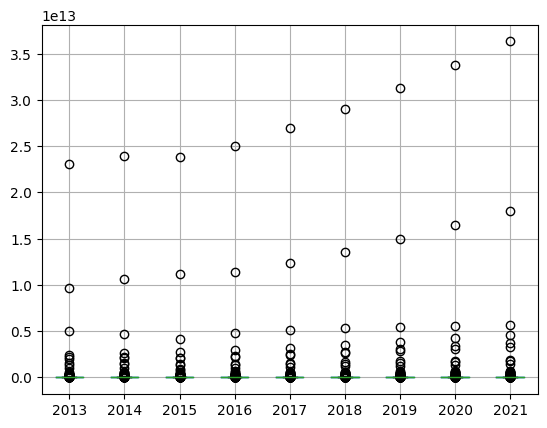

In [350]:
dataset.boxplot(column=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

**Standardizing the dataset** and converting it into a numpy array

In [351]:
dataset = standardize(dataset)
dataset_np = np.array(dataset)
dataset.head()

,Country Code,Indicator Code,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.371501,1.314656,-0.103539,-0.10389,-0.103936,-0.104102,-0.103409,-0.102994,-0.102675,-0.10234,-0.102122
1,0.458192,1.314656,-0.103539,-0.10389,-0.103936,-0.104102,-0.103409,-0.102994,-0.102675,-0.10234,-0.102122
2,0.544884,1.314656,-0.103539,-0.10389,-0.103936,-0.104102,-0.103409,-0.102994,-0.102675,-0.10234,-0.102122
3,0.631575,1.314656,-0.103539,-0.10389,-0.103936,-0.104102,-0.103409,-0.102994,-0.102675,-0.10234,-0.102122
4,-1.102253,1.314656,-0.103539,-0.10389,-0.103936,-0.104102,-0.103409,-0.102994,-0.102675,-0.10234,-0.102122


###**Main Function**

In [352]:
##### Step 1 #####
clustering = KMeans(dataset_np, k=3, max_iter=20)         # K Means Clustering for k = 3

##### Step 2 #####
score = SC(dataset_np, clustering[0])                     # Silhouette Score calculation
print(f'The Silhouette Score on performing K Means clustering using k = 3 for 20 iterations is {score : .6f}.\n')

##### Step 3 #####
print('---------------------------------------------------------------------')
best_k = find_best_k(dataset_np)                          # computing the best value of k
print(f'\nThe best Silhouette Score is obtained for k = {best_k}.\n')
print('The clustering information for each value of k is saved in appropriate text files.\n')

##### Step 4 #####
print('---------------------------------------------------------------------')
clustering = CLDC(dataset_np, best_k)                     # performing CLDC using the best_k obtained
score = SC(dataset_np,clustering[0])                      # Silhouette Score calculation
print(f'\nThe Silhouette Score on performing Complete Linkage Divisive Clustering using the optimal value of k is {score : .6f}.\n')
print('The clustering information of Complete Linkage Divisive Clustering is also saved in an appropriate text file.\n')

##### Final Step #####
print('---------------------------------------------------------------------')
clustering1 = KMeans(dataset_np, best_k)
clustering2 = CLDC(dataset_np, best_k)
scores = mapping_Jaccard(clustering1[1], clustering2[1])  # printing the Jaccard Similarity scores

The Silhouette Score on performing K Means clustering using k = 3 for 20 iterations is  0.532896.

---------------------------------------------------------------------

The Silhouette Score on using k = 3 is  0.532896

The Silhouette Score on using k = 4 is  0.638726

The Silhouette Score on using k = 5 is  0.700798

The Silhouette Score on using k = 6 is  0.664164

The best Silhouette Score is obtained for k = 5.

The clustering information for each value of k is saved in appropriate text files.

---------------------------------------------------------------------

The Silhouette Score on performing Complete Linkage Divisive Clustering using the optimal value of k is  0.658933.

The clustering information of Complete Linkage Divisive Clustering is also saved in an appropriate text file.

---------------------------------------------------------------------

The mapping of clusters is as follows : 

0 ---> 0	1 ---> 1	2 ---> 2	3 ---> 3	4 ---> 4	
The Jaccard Similarity values of the co